# Batch Optimization

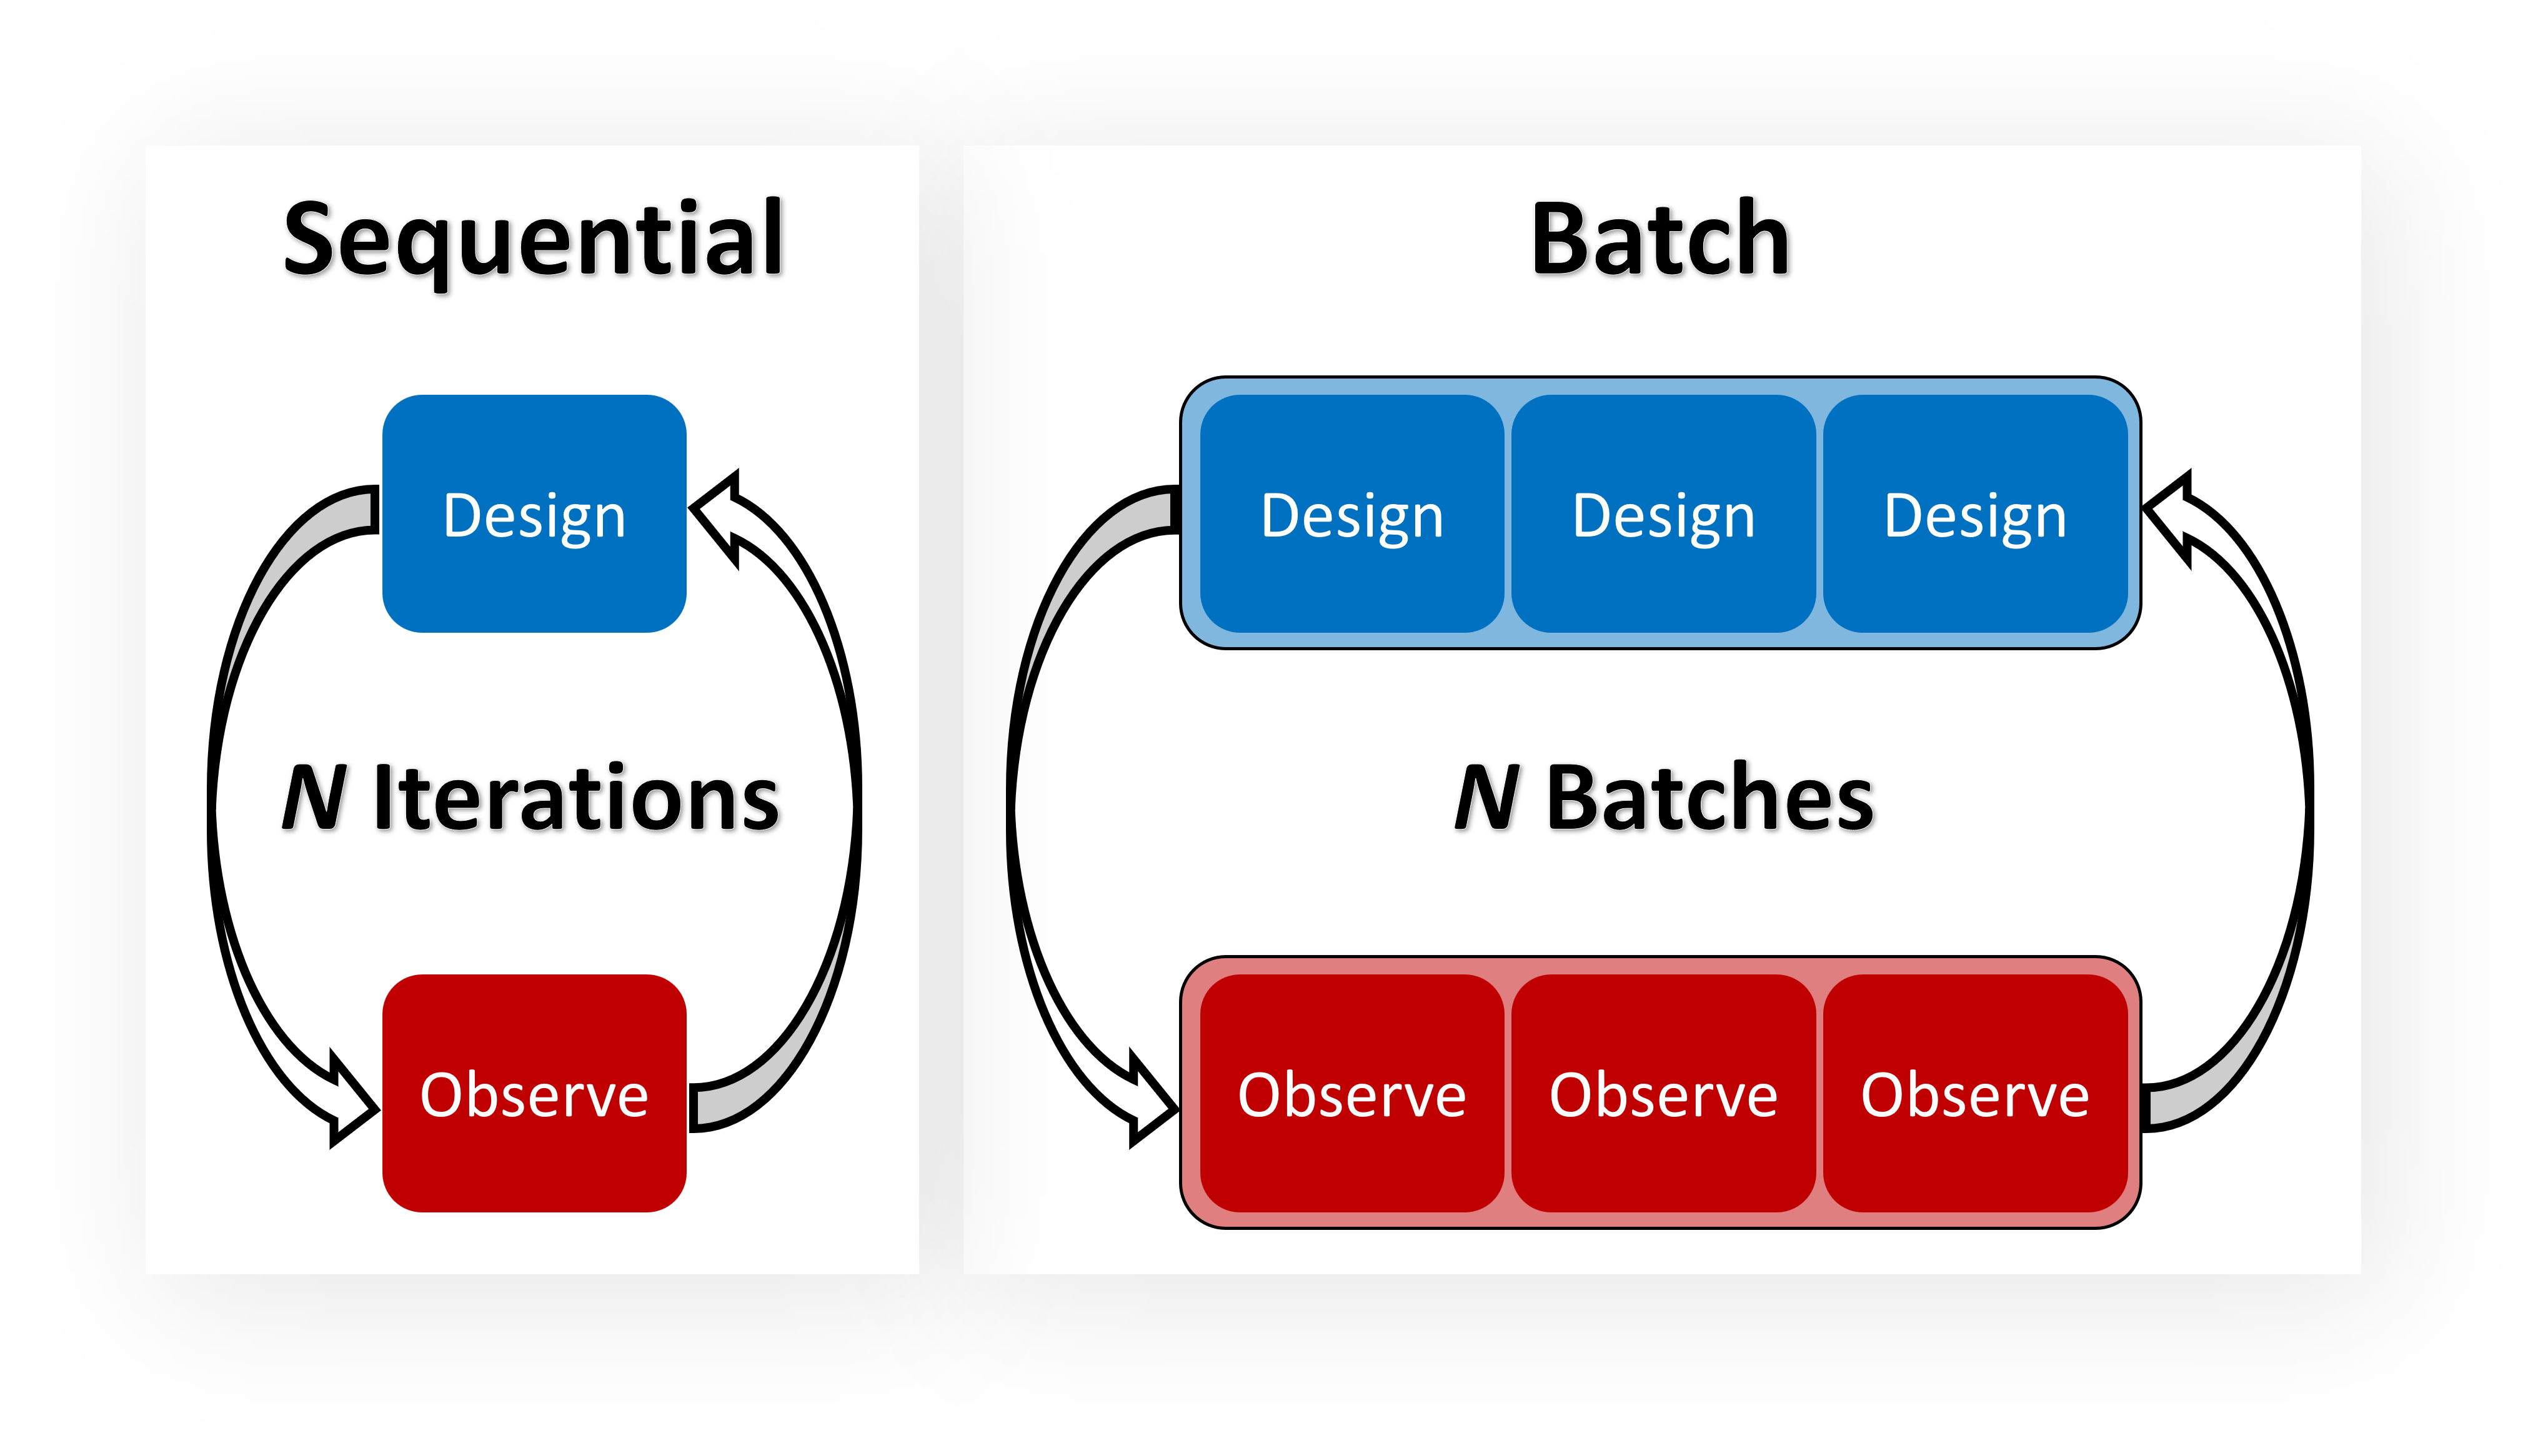

In [1]:
# For notebook gallery thumbnail
from IPython.display import Image
Image(filename="./sequential-vs-batch-schematic.png")

Previously, we looked at multi-fidelity optimization. In this notebook, we will look at
batch optimization in the context of networking a set of cloud-based experiments
together. Batch optimization is a technique that allows us to evaluate
multiple points at once. This can be useful when we have a computationally expensive
objective function, and we want to evaluate multiple points at once to reduce the
overall time it takes to find the optimal point.

With batch optimization, suggested points should not be decided on independently from
one another. This can lead to highly inefficient searches. For example, what if you end
up suggesting practically the same point over and over again? Instead, we should try to choose points that are likely to be good
together. This is a technique called "batch conditioning". A naive approach to batch
conditioning that's easy to understand is via what's called "fantasy models". While Ax
uses a more sophisticated Monte Carlo approach, this gets the point across.

![](https://github.com/sparks-baird/self-driving-lab-demo/blob/main/notebooks/sequential-vs-fantasy-batch-conditioning.png?raw=true)


See the following resources for additional context:

- [Batching (BoTorch
docs)](https://botorch.org/docs/batching#batch-acquisition-functions)
- [Discussion about batch conditioning methods (GitHub issue)](https://github.com/facebook/Ax/issues/778#issuecomment-1013762749)
- [Why do I need to condition batches during Bayesian optimization? (YouTube)](https://www.youtube.com/watch?v=JzgkSR6FFyM&t=2s)

In this notebook, we'll compare the tradeoff between clock runtime and number of
experimental evaluations as a function of batch size. We'll compare batch sizes of 1, 2,
and 3. This notebook assumes access to multiple physical SDL-Demo's. While the
experiments can be in the same location, they could also be set up in multiple
locations: for example, one in Utah, one in Ohio, and one in Singapore. This notebook
performs the "central brain" functions of requesting experiments from each of the
individual experiments and making decisions based on the collective data.

For now, we'll
perform the decision making in sequential batches; however, later on we will take a look at
asynchronous optimization, where decisions for next experiments are made on-the-fly as
soon as experimental resources are made available.

In [1]:
try:
    import google.colab
    %pip install self-driving-lab-demo
except:
    pass

Instead of instantiating one class per campaign, we'll instantiate multiple per
campaign. Each will have the same `target_seed`, meaning the RGB color that each
experiment is trying to match (within a given campaign) will effectively be the same. If you don't have access to multiple demos, you can toggle the
`only_one_available` flag to `True` which treats the public demo as if it were three
separate devices. However, this should not be used to compare performance across batch
sizes, since there's only one physical experimental device.

This also assumes that you have a file named `secrets.json` in the same directory as this notebook that looks
like the following:
```json
{
    "PICO_ID_0": "test",
    "PICO_ID_1": "e66141abc123def456",
    "PICO_ID_2": "e66141ghi789jkl012"
}

```
Note that `"e66141abc123def456"` and `"e66141ghi789jkl012"` are fake IDs, so you'll need
to replace these with ones that correspond to real devices. You can leave `"test"`
as-is, since this corresponds to the public SDL-Demo, or you can replace this with your own.

In [2]:
from uuid import uuid4  # universally unique identifier
from self_driving_lab_demo import SelfDrivingLabDemo, mqtt_observe_sensor_data
import json

only_one_available = False  # @param {type:"boolean"}

if only_one_available:
    # pretend like the public demo is three different devices
    pico_ids = ["test", "test", "test"]
else:
    # # use two additional devices
    with open("secrets.json") as f:
        secrets = json.load(f)
        PICO_ID_0 = secrets["PICO_ID_0"] # public test demo
        PICO_ID_1 = secrets["PICO_ID_1"]
        PICO_ID_2 = secrets["PICO_ID_2"]
    pico_ids = [PICO_ID_0, PICO_ID_1, PICO_ID_2]

dummy = True # @param {type:"boolean"}

if dummy:
    num_repeats  = 2
    num_iter = 9
else:
    num_repeats = 5  # @param {type:"integer"}
    num_iter = 20  # @param {type:"integer"}
    
    
simulation = False  # @param {type:"boolean"}
SESSION_IDS = [str(uuid4()) for _ in range(3)]  # random session IDs
seeds = range(10, 10 + num_repeats)
print(f"session IDs: {SESSION_IDS}")

sdl_batches = [
    [
        SelfDrivingLabDemo(
            autoload=True,  # perform target data experiment automatically
            simulation=simulation,
            observe_sensor_data_fn=mqtt_observe_sensor_data,  # (default)
            observe_sensor_data_kwargs=dict(pico_id=pico_id, session_id=session_id),
            target_seed=seed,
        )
        for pico_id, session_id in zip(pico_ids, SESSION_IDS)
    ]
    for seed in seeds
]


session IDs: ['d950fcca-a35a-4240-b57e-145925a6491f', 'debeb21e-291b-4499-a16b-d2034e020901', '4c218b0a-b10f-4caa-89b1-f95fe49cc439']


In [3]:
sdl = sdl_batches[0][0]
bounds = dict(R=sdl.bounds["R"], G=sdl.bounds["G"], B=sdl.bounds["B"])
params = [dict(name=nm, type="range", bounds=bnd) for nm, bnd in bounds.items()]
params

[{'name': 'R', 'type': 'range', 'bounds': [0, 89]},
 {'name': 'G', 'type': 'range', 'bounds': [0, 89]},
 {'name': 'B', 'type': 'range', 'bounds': [0, 89]}]

In order to actually run the experiments in parallel, we'll need to use separate CPU threads
(i.e. run each experiment on a different process). For this, we'll use [Ray](https://docs.ray.io/en/latest/index.html), though
you could also use `multiprocessing` or some other library. The implementation is based
on [this stack exchange post](https://stackoverflow.com/a/54564836/13697228).

In [12]:
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.service.utils.instantiation import ObjectiveProperties
import ray

ax_clients = []
batch_size = 3
num_sobol = 6
objectives = {"frechet": ObjectiveProperties(minimize=True)}

batch_results = []


ray.shutdown()
ray.init(num_cpus=batch_size)
for sdl_batch in sdl_batches:
    
    # TODO: track the clock time it takes for each campaign to complete

    @ray.remote
    def evaluate(parameters, sdl_num):
        R = parameters["R"]
        G = parameters["G"]
        B = parameters["B"]
        results = sdl_batch[sdl_num].evaluate(R=R, G=G, B=B)
        # remove some entries to prevent extra tracking metrics warnings
        [results.pop(ch) for ch in sdl.channel_names]
        [results.pop(name) for name in ["mae", "rmse"]]
        return results

    gs = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_sobol),
            GenerationStep(model=Models.GPEI, num_trials=num_iter - num_sobol),
        ]
    )

    ax_client = AxClient(generation_strategy=gs)
    ax_client.create_experiment(
        name="sdl-demo-batch",
        parameters=params,
        objectives=objectives,
        overwrite_existing_experiment=True,
    )

    optimization_complete = False
    while not optimization_complete:
        trials_dict, optimization_complete = ax_client.get_next_trials(
            max_trials=batch_size
        )
        # start running the batch of experiments in parallel
        futures = [
                evaluate.remote(parameters, sdl_num)
                for sdl_num, parameters in enumerate(trials_dict.values())
            ]
        # block until the batch of experiments finishes running
        results = ray.get(futures)

        # add results to the optimizer
        for trial_index, raw_data in zip(trials_dict.keys(), results):
            ax_client.complete_trial(trial_index=trial_index, raw_data=raw_data)

    ax_clients.append(ax_client)

2022-10-22 16:57:36,318	INFO worker.py:1518 -- Started a local Ray instance.
[INFO 10-22 16:57:37] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 10-22 16:57:37] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter R. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-22 16:57:37] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter G. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-22 16:57:37] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter B. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'boo

In [5]:
results = [ax_client.get_best_parameters() for ax_client in ax_clients]

[WARNING 10-22 16:37:49] ax.modelbridge.cross_validation: Metric frechet was unable to be reliably fit.
[WARNING 10-22 16:37:49] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 10-22 16:37:49] ax.service.utils.best_point: Model fit is poor and data on objective metric frechet is noisy; interpret best points results carefully.
[WARNING 10-22 16:37:49] ax.modelbridge.cross_validation: Metric frechet was unable to be reliably fit.
[WARNING 10-22 16:37:49] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 10-22 16:37:49] ax.service.utils.best_point: Model fit is poor and data on objective metric frechet is noisy; interpret best points results carefully.


In [9]:
best_errors = [result[1][0]["frechet"] for result in results]
best_parameters = [result[0] for result in results]
print(list(zip(best_parameters, best_errors)))

[({'R': 89, 'G': 65, 'B': 77}, 1785.4481230212207), ({'R': 81, 'G': 24, 'B': 3}, 3748.416332266201)]


## Code Graveyard

    # for trial_index, parameters in trials_dict.items():
    #     ax_client.complete_trial(
    #         trial_index=trial_index, raw_data=evaluate(parameters)
    #     )